Group Project Report 

Next steps:
1. Build the recipe using user_knowledge as the classifier, study_time_goal and performance_goal as the predictors, and the training set as the data.
2. Choose the appropriate K-value for the training set using 5-fold cross-validation and compare accuracy for each selection of K (tune the model)
3. Create the KNN model using the selected K value
4. Train the classifier using the training set
5. Predict the labels for the unseen testing set
6. Evaluate accuracy and create a confusion matrix to assess precision and recall
7. Analyze performance using precision, recall, and accuracy
8. Discuss outcomes and provide suggestions for improving the model

Work done on our proposal:

In [22]:
#load all the necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("RColorBrewer")
library(RColorBrewer)
install.packages("kknn") 
library("kknn")

#read data from the web (GitHub raw file)
url <- "https://raw.githubusercontent.com/afellhauer/DSCI_Group_Project/main/data/Data_User_Modeling_Dataset_Hamdi.csv"
knowledge <- read_csv(url)
head(knowledge)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Rows: 258 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


In [23]:
knowledge_mutate <- knowledge |>
    mutate(UNS = as_factor(UNS)) |> #change the class from a chr to a factor
    rename("study_time_goal" = STG, #relabel all variables to understand them better
           "repetition" = SCG,
           "study_time_related" = STR,
           "performance_related" = LPR, 
           "performance_goal" = PEG,
           "user_knowledge" = UNS)

head(knowledge_mutate)

missing <- sum(is.na(knowledge_mutate)) # check for missing values
print(paste("Number of missing values: ", missing))

study_time_goal,repetition,study_time_related,performance_related,performance_goal,user_knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


[1] "Number of missing values:  0"


In [24]:
set.seed(200) #set seed to be reproducible
#create the initial split of the data

#stratify based on user_knowledge
knowledge_split <- initial_split(knowledge_mutate, prop = 0.75, strata = user_knowledge)

#collected the testing and training portions
knowledge_training <- training(knowledge_split)
knowledge_testing <- testing(knowledge_split)

glimpse(knowledge_training) #see that the number of rows is less than the dataset

Rows: 192
Columns: 6
$ study_time_goal     <dbl> 0.080, 0.180, 0.100, 0.090, 0.080, 0.200, 0.130, 0…
$ repetition          <dbl> 0.080, 0.180, 0.100, 0.300, 0.325, 0.450, 0.390, 0…
$ study_time_related  <dbl> 0.100, 0.550, 0.700, 0.680, 0.620, 0.280, 0.850, 0…
$ performance_related <dbl> 0.24, 0.30, 0.15, 0.18, 0.94, 0.31, 0.38, 0.71, 0.…
$ performance_goal    <dbl> 0.90, 0.81, 0.90, 0.85, 0.56, 0.78, 0.77, 0.90, 0.…
$ user_knowledge      <fct> High, High, High, High, High, High, High, High, Hi…


**STEP 1: Build the recipe using user_knowledge as the classifier, study_time_goal and performance_goal as the predictors, and the training set as the data.**

In [25]:
knowledge_recipe <- recipe(user_knowledge ~ study_time_goal + performance_goal, data = knowledge_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 
knowledge_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

**STEP 2: Choose the appropriate K-value for the training set using 5-fold cross-validation and compare accuracy for each selection of K (tune the model)**

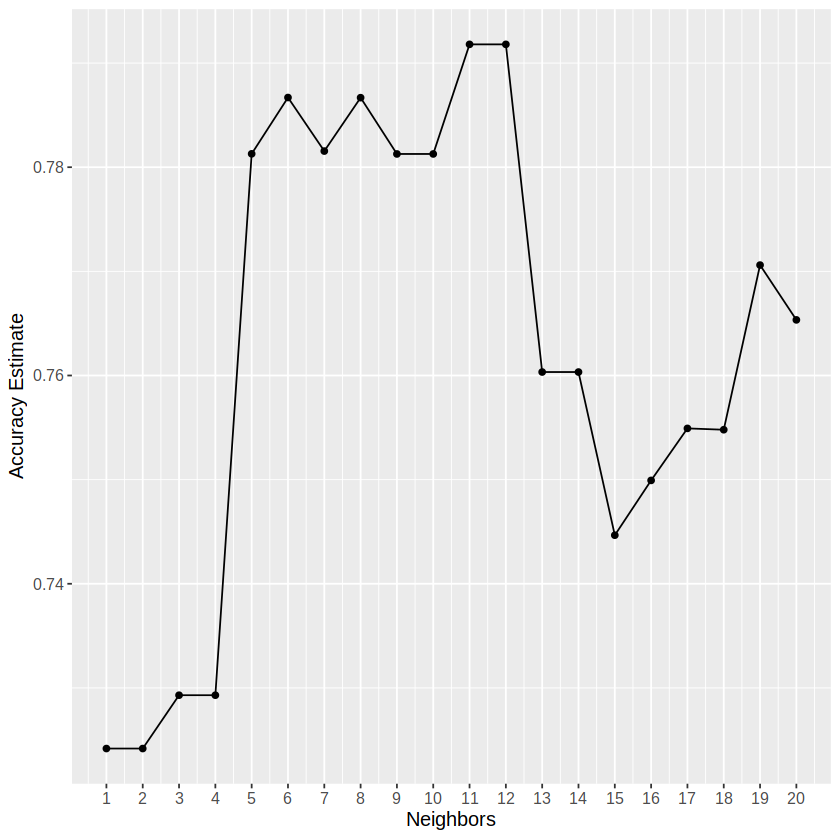

In [26]:
knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = user_knowledge)

knowledge_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knowledge_fit <- workflow() |>
  add_recipe(knowledge_recipe) |>
  add_model(knowledge_spec) |>
  tune_grid(resamples = knowledge_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knowledge_fit |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
  scale_x_continuous(breaks = 1:20)

accuracy_vs_k

Looking at the graph above, we will chose K = 11 as our K-value.

**STEP 3: Create the KNN model using the selected K value**

In [27]:
know_spec_best <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 11) |>
  set_engine("kknn") |>
  set_mode("classification")
know_spec_best

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 11
  weight_func = rectangular

Computational engine: kknn 


**STEP 4: Train the classifier using the training set**

In [28]:
#Create new workflow using the training set
knowledge_best <- workflow() |>
  add_recipe(knowledge_recipe) |>
  add_model(know_spec_best)|>
    fit(knowledge_training)

knowledge_best

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2395833
Best kernel: rectangular
Best k: 11

In [47]:
#Test effectiveness of workflow with training set

predict_train <- predict(knowledge_best , knowledge_training)|>
                        bind_cols(knowledge_training)

head(predict_train)

accuracy_train<-predict_train|>
                        metrics(truth = user_knowledge, estimate = .pred_class)

accuracy_train

.pred_class,study_time_goal,repetition,study_time_related,performance_related,performance_goal,user_knowledge
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
High,0.08,0.080,0.10,0.24,0.90,High
High,0.18,0.180,0.55,0.30,0.81,High
High,0.10,0.100,0.70,0.15,0.90,High
High,0.09,0.300,0.68,0.18,0.85,High
Middle,0.08,0.325,0.62,0.94,0.56,High
High,0.20,0.450,0.28,0.31,0.78,High


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7968750
kap,multiclass,0.7123651


**STEP 5: Predict the labels for the unseen testing set**

In [39]:
#Predicting the testing set
predict_test <- predict(knowledge_best , knowledge_testing)|>
                        bind_cols(knowledge_testing)

accuracy_test<-predict_test|>
                        metrics(truth = user_knowledge, estimate = .pred_class)

accuracy_test

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8636364
kap,multiclass,0.8017356


ANALYSIS: Accuracy at 86%, can be considered high.

**STEP 6: Evaluate accuracy and create a confusion matrix to assess precision and recall**

In [42]:
test_mat <- predict_test |> 
      conf_mat(truth = user_knowledge, estimate = .pred_class)
test_mat

          Truth
Prediction very_low High Low Middle
  very_low        2    0   1      0
  High            0   15   0      1
  Low             2    0  23      4
  Middle          0    1   0     17

**STEP 7: Analyze performance using precision, recall, and accuracy**